In [1]:
# importing lib

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score

# Reading the data
train = pd.read_csv("train_file.csv")
test = pd.read_csv("test_file.csv")
test_original=test.copy()

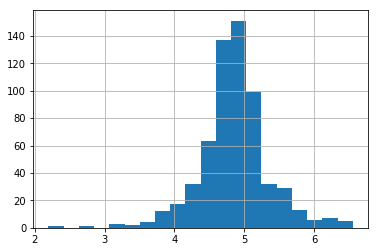

In [2]:
# Handling the missing values and outliers as, we see in the univariate 
# Missing values
# train.isnull().sum()
# For categorial data
train['Gender'].fillna(train['Gender'].mode()[0],inplace=True)
train['Married'].fillna(train['Married'].mode()[0],inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0],inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

# For numerical data
# We can't take mean because mean effect the value
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

# Same goes for test
test['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

# Outlier Treatment
train['LoanAmount_log'] = np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)
test['LoanAmount_log'] = np.log(test['LoanAmount'])

In [3]:
# Model Building : Part I
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

X = train.drop('Loan_Status',1) 
y = train.Loan_Status

# Creating Dummy variable
X=pd.get_dummies(X) 
train=pd.get_dummies(train) 
test=pd.get_dummies(test)

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3)

# Logistic Regression
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

# model = LogisticRegression() 
# model.fit(x_train, y_train)

# pred_cv = model.predict(x_cv)
# accuracy_score(y_cv,pred_cv)

# pred_test = model.predict(test)
submission=pd.read_csv("sample_submission_S7jWYrJ.csv")
# submission['Loan_Status']=pred_test 
# submission['Loan_ID']=test_original['Loan_ID']
# submission['Loan_Status'].replace(0, 'N',inplace=True) 
# submission['Loan_Status'].replace(1, 'Y',inplace=True)
# # submission.dropna(how='all', axis='columns')
# pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('logistic.csv',index=False)

In [20]:
# Logistic Regression using Stratified k-folds cross validation

# import StratifiedKFold from sklearn and fit the model
from sklearn.model_selection import StratifiedKFold

# ross validation logistic model with stratified 5 folds
i=1
kf=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.loc[train_index],X.loc[test_index]
    ytr,yvl=y[train_index],y[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy_score ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score  0.7983870967741935

2 of kfold 5
accuracy_score  0.8306451612903226

3 of kfold 5
accuracy_score  0.8114754098360656

4 of kfold 5
accuracy_score  0.7950819672131147

5 of kfold 5
accuracy_score  0.8278688524590164


In [36]:
# # visualize the roc curve.
# from sklearn import metrics
# fpr, tpr, _ = metrics.roc_curve(yvl,  pred) 
# auc = metrics.roc_auc_score(yvl, pred)
# plt.figure(figsize=(12,8))
# plt.plot(fpr,tpr,label="validation, auc="+str(auc))
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc=4)
# plt.show()

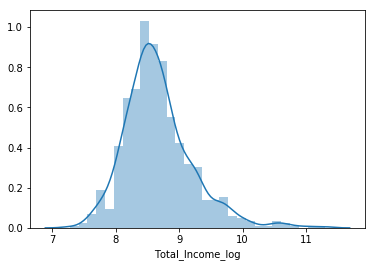

In [5]:
# Feature Engineering to improve the accuracy

# Total Income - As discussed during bivariate analysis we will combine the Applicant Income and Coapplicant Income. If the total income is high, chances of loan approval might also be high.
# EMI - EMI is the monthly amount to be paid by the applicant to repay the loan. Idea behind making this variable is that people who have high EMI’s might find it difficult to pay back the loan. We can calculate the EMI by taking the ratio of loan amount with respect to loan amount term.
# Balance Income - This is the income left after the EMI has been paid. Idea behind creating this variable is that if this value is high, the chances are high that a person will repay the loan and hence increasing the chances of loan approval.

train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']

# distribution of Total Income.
# sns.distplot(train['Total_Income'])

# make the distributio nnormal
train['Total_Income_log'] = np.log(train['Total_Income'])
sns.distplot(train['Total_Income_log']); 
test['Total_Income_log'] = np.log(test['Total_Income'])

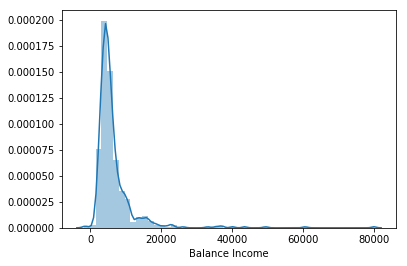

In [6]:
# EMI feature now.
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']

# distribution of EMI variable.
# sns.distplot(train['EMI'])

# create Balance Income feature now and check its distribution.
train['Balance Income']=train['Total_Income']-(train['EMI']*1000)
# Multiply with 1000 to make the units equal
test['Balance Income']=test['Total_Income']-(test['EMI']*1000)
sns.distplot(train['Balance Income'])

In [7]:
# Drop : Reason: correlation between those old features and these new features 
# will be very high and LR assumes that the variables are not highly correlated
train=train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1) 
test=test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

In [35]:
# Model Building : Part II
# Logistic Regression
# Decision Tree
# Random Forest
# XGBoost

In [8]:
# Logistic Regression using StraifiedKFold
from sklearn.model_selection import StratifiedKFold

# cross validation logistic model with stratified 5 folds
i=1
kf=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.loc[train_index],X.loc[test_index]
    ytr,yvl=y[train_index],y[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy_score ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xvl)[:,1]

submission['Loan_Status']=pred_test    # filling Loan_Status with predictions
submission['Loan_ID']=test_original['Loan_ID']   # filling Loan_ID with test Loan_ID

# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Log2.csv',index=False)


1 of kfold 5
accuracy_score  0.7983870967741935

2 of kfold 5
accuracy_score  0.8306451612903226

3 of kfold 5
accuracy_score  0.8114754098360656

4 of kfold 5
accuracy_score  0.7950819672131147

5 of kfold 5
accuracy_score  0.8278688524590164


In [41]:
# Decission Tree
from sklearn import tree

# ross validation logistic model with stratified 5 folds
i=1
kf=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.loc[train_index],X.loc[test_index]
    ytr,yvl=y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy_score ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xvl)[:,1]

submission['Loan_Status']=pred_test            # filling Loan_Status with predictions
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID

# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Decision Tree.csv',index=False)


1 of kfold 5
accuracy_score  0.6693548387096774

2 of kfold 5
accuracy_score  0.7096774193548387

3 of kfold 5
accuracy_score  0.6721311475409836

4 of kfold 5
accuracy_score  0.6721311475409836

5 of kfold 5
accuracy_score  0.7213114754098361


In [47]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# ross validation logistic model with stratified 5 folds
i=1
kf=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.loc[train_index],X.loc[test_index]
    ytr,yvl=y[train_index],y[test_index]
    model = RandomForestClassifier(random_state=1,max_depth=3,n_estimators=41)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy_score ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xvl)[:,1]

# mean validation accuracy for this model is 0.766
# improve the accuracy by tuning the hyperparameters for this model
# we will use grid search to get the optimized values of hyper parameters
# Grid-search is a way to select the best of a family of hyper parameters, parametrized by a grid of parameters.
# tune the max_depth and n_estimators parameters.
# max_depth decides the maximum depth of the tree
# n_estimators decides the number of trees that will be used in random forest model
from sklearn.model_selection import GridSearchCV

# Provide range for max_depth from 1 to 20 with an interval of 2 and
# from 1 to 200 with an interval of 20 for n_estimators 

paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)

from sklearn.model_selection import train_test_split 
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3, random_state=1)

# Fit the grid search model 
grid_search.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=None, max_features='auto', max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,oob_score=False, random_state=1, verbose=0, warm_start=False),       
fit_params=None, iid=True, n_jobs=1,       
param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]},       
pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',       
scoring=None, verbose=0)

# Estimating the optimized value 
grid_search.best_estimator_
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=3, max_features='auto', max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,
min_samples_leaf=1, min_samples_split=2,            
min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,            
oob_score=False, random_state=1, verbose=0, warm_start=False)

submission['Loan_Status']=pred_test            # filling Loan_Status with predictions
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID

# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('RandomForest.csv',index=False)


1 of kfold 5
accuracy_score  0.7983870967741935

2 of kfold 5
accuracy_score  0.8306451612903226

3 of kfold 5
accuracy_score  0.8032786885245902

4 of kfold 5
accuracy_score  0.7868852459016393

5 of kfold 5
accuracy_score  0.8278688524590164
